In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# imports
path_to_prep_mum = 'data/data_prepared/mums_prep.csv'
path_to_prep_dad = 'data/data_prepared/dads_prep.csv'
df_dads = pd.read_csv(path_to_prep_dad)
df_dads['dad_value_numeric_rescale'] = df_dads.dad_value_numeric /10**6


path_to_prepared_data = 'data/data_prepared/only_stalions_prepared.csv'
df = pd.read_csv(path_to_prepared_data)
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40 non-null     int64  
 1   kid_id             40 non-null     int64  
 2   mum_id             40 non-null     object 
 3   dad_id             40 non-null     object 
 4   value_numeric      40 non-null     float64
 5   first_place        40 non-null     int64  
 6   dad_value_numeric  40 non-null     float64
 7   dad_first_place    40 non-null     float64
 8   dad_second_place   40 non-null     float64
 9   dad_third_place    40 non-null     float64
 10  dad_num_of_starts  40 non-null     float64
dtypes: float64(6), int64(3), object(2)
memory usage: 3.6+ KB


In [4]:
# rescaling values
for column in ['value_numeric', 'dad_value_numeric']:
    new_col = column + '_rescale'
    df[new_col] = df[column]/10**6
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,value_numeric_rescale,dad_value_numeric_rescale
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0,0.132570,0.156410
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0,0.631605,1.749869
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0,0.008963,0.580806
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0,0.004799,0.580806
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0,0.209211,1.176781


# histogram of data we want to predict

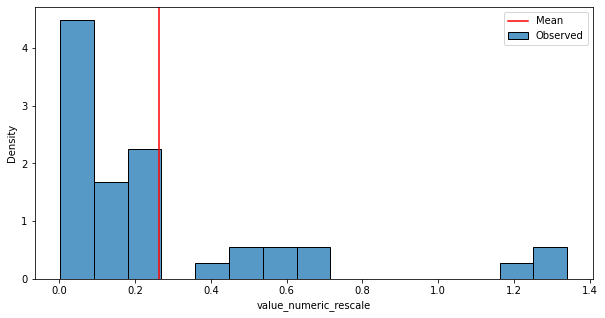

In [5]:
# analysis of value: what we want to to predict
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df, x='value_numeric_rescale', bins=15, ax=axs, label='Observed', stat='density')
graph.axvline(df.value_numeric_rescale.mean(), color='red', label='Mean')
graph.legend()
plt.show()

# histograms of data we want to predict from


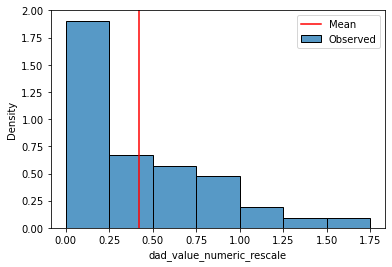

In [6]:
# histograms of data we want to predict from
graph = sns.histplot(data=df_dads, x='dad_value_numeric_rescale', label='Observed', stat='density')
graph.axvline(df_dads.dad_value_numeric_rescale.mean(), color='red', label='Mean')
graph.legend()
plt.show()

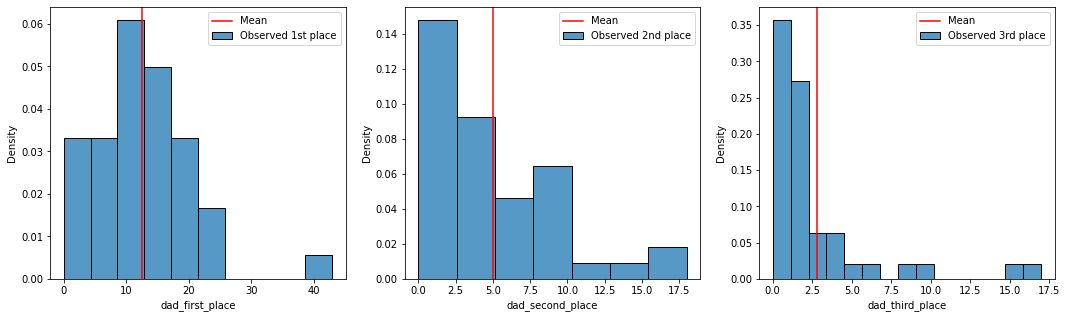

In [7]:
# places of dad
fig, axs = plt.subplots(1,3, figsize=(18,5))
graph = sns.histplot(data=df_dads, x='dad_first_place', label='Observed 1st place', ax=axs[0], stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_second_place', label='Observed 2nd place', ax=axs[1], stat='density')
graph.axvline(df_dads.dad_second_place.mean(), label='Mean', color='red')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_third_place', label='Observed 3rd place', ax=axs[2], stat='density')
graph.axvline(df_dads.dad_third_place.mean(), label='Mean', color='red')
graph.legend()
plt.show()

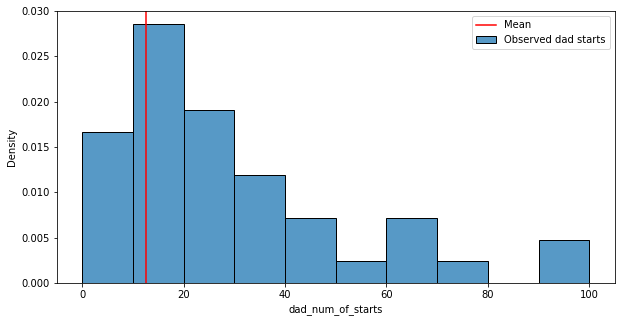

In [8]:
# nums of starts
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_dads, x='dad_num_of_starts', label='Observed dad starts', ax=axs, bins=10, stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()
plt.show()


Assumed prior distributions:
- `dad_num_of_starts` : lognormal
- `dad_value_numeric_rescale` : exponential
- `dad_first_place` : lognormal
- `dad_second_place` : exponential
- `dad_third_place` : expnoential

In [84]:
def log_maker(mu,sigma):
    log_mu = np.log((mu**2)/np.sqrt(mu**2 + sigma**2))    
    log_sigma = np.sqrt(np.log(1+(sigma**2 )/(mu**2)))
    return log_mu,log_sigma

# calculating needed parameters for prior distributions
# to use in stan models in a bit

# dad_num_of_starts
mu_dad_num_of_starts, sigma_dad_num_of_starts = log_maker(df_dads.dad_num_of_starts.mean(),df_dads.dad_num_of_starts.std())
# mu_dad_num_of_starts = df_dads.dad_num_of_starts.mean()
# sigma_dad_num_of_starts = df_dads.dad_num_of_starts.std()

# dad_value_numeric_rescale
lambda_dad_value_numeric_rescale = 1/df_dads.dad_value_numeric_rescale.mean()

# dad_first_place
mu_dad_first_place, sigma_dad_first_place = log_maker(df_dads.dad_first_place.mean(),df_dads.dad_first_place.std())
# mu_dad_first_place = df_dads.dad_first_place.mean()
# sigma_dad_first_place = df_dads.dad_first_place.std()

# dad_second_place
lambda_dad_second_place = 1/df_dads.dad_second_place.mean()

# dad_third_place
lambda_dad_third_place = 1/df_dads.dad_third_place.mean()



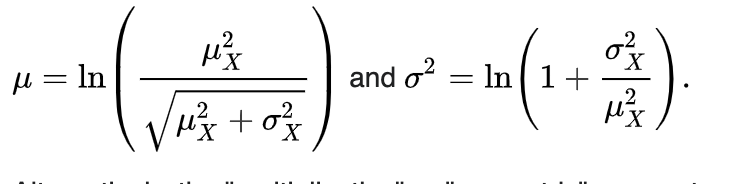

In [83]:
def log_maker(mu,sigma):
    log_mu = np.log((mu**2)/np.sqrt(mu**2 + sigma**2))    
    log_sigma = np.sqrt(np.log(1+(sigma**2 )/(mu**2)))
    return log_mu,log_sigma

In [13]:
with open('models/distribution_check.stan') as file:
    print(file.read())
    file.close()

data {
    real mu_dad_num_of_starts;
    real sigma_dad_num_of_starts;
    real mu_dad_first_place;
    real sigma_dad_first_place;
    real lambda_dad_value_numeric_rescale;
    real lambda_dad_second_place;
    real lambda_dad_third_place;
}

generated quantities {
    real<lower=0> first_place = lognormal_rng(mu_dad_first_place, sigma_dad_first_place); 
    real<lower=0> num_of_start= lognormal_rng(mu_dad_num_of_starts, sigma_dad_num_of_starts);
    real<lower=0> value_numeric= exponential_rng(lambda_dad_value_numeric_rescale);
    real<lower=0> second_place = exponential_rng(lambda_dad_second_place);
    real<lower=0> third_place = exponential_rng(lambda_dad_third_place);
    
    real life_expectancy = exponential_rng(1/num_of_start);
}


In [90]:
m_distribution_check=CmdStanModel(stan_file='models/distribution_check.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes_git/models/distribution_check.stan to exe file /home/racehorse_bayes_git/models/distribution_check
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes_git/models/distribution_check


In [91]:
data = {
        'mu_dad_num_of_starts': mu_dad_num_of_starts,
        'sigma_dad_num_of_starts': sigma_dad_num_of_starts,
        'mu_dad_first_place': mu_dad_first_place,
        
        "sigma_dad_first_place": sigma_dad_first_place,
        "lambda_dad_value_numeric_rescale": lambda_dad_value_numeric_rescale,
        "lambda_dad_second_place": lambda_dad_second_place,
        "lambda_dad_third_place": lambda_dad_third_place,
        
}


sim1_distribution_check=m_distribution_check.sample(data=data, seed=26062023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [96]:
ppc_distribution_chceck = sim1_distribution_check.draws_pd()
ppc_distribution_chceck.head()

,lp__,accept_stat__,first_place,num_of_start,value_numeric,second_place,third_place,kid_value
0,0.0,0.0,10.68090,11.44380,0.098246,6.576850,2.449920,6.52996
1,0.0,0.0,10.45340,7.72026,0.522891,7.804130,5.788230,7.52794
2,0.0,0.0,10.79360,5.80172,0.216147,11.636500,7.014390,1.05798
3,0.0,0.0,5.20312,18.68280,0.616947,3.635910,4.872110,11.37120
4,0.0,0.0,5.92817,68.54260,0.175233,0.998682,0.527363,164.92900


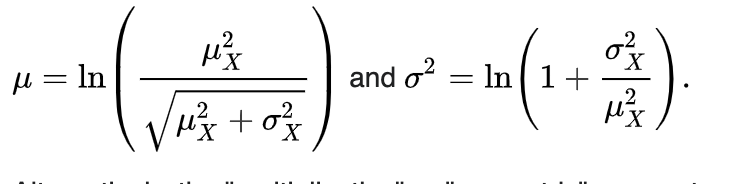

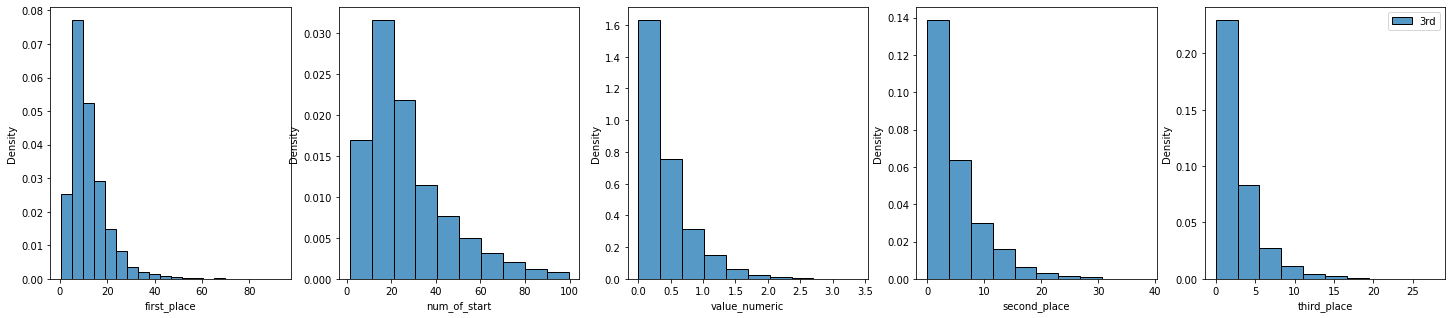

In [97]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['first_place']<100], x='first_place', label='Observed starts', ax=axs[0],bins=20,stat='density')

# graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')

graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['num_of_start']<100], x='num_of_start', label='Observed starts', ax=axs[1],bins=10,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['value_numeric']<100], x='value_numeric', label='value_numeric', ax=axs[2],bins=10,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['second_place']<100], x='second_place', label='2nd', ax=axs[3],bins=10,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['third_place']<100], x='third_place', label='3rd', ax=axs[4],bins=10,stat='density')

graph.legend()
plt.show()

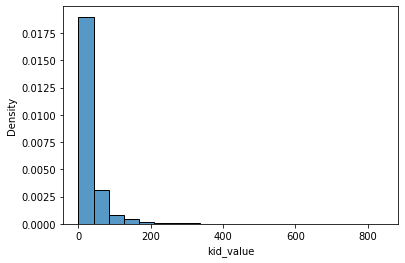

In [99]:

graph = sns.histplot(data=ppc_distribution_chceck, x='kid_value', label='Kid_value' ,bins=20,stat='density')